# Chapter 17: Play Breakout with Policy Gradients

We extend the policy gradients approach you learned in Chapter 16 to another, more complicated Atari game, Breakout. 

Specifically, since the possible actions are four instead of just two, you need to change the problem from binary classification to multi-class classification. Further, you need to change the reward system of the game by counting the number of lives remaining for the agent. A more nuanced reward system will greatly improve the training. 

You'll also learn the limitations of the policy gradients in training the Breakout game. When taking the difference of two consecutive frames, the layers of bricks disappear and this affects later stages of the game. 

Non-the-less, the agent will learn to send the ball to the back to layers of bricks to score more efficiently. You'll learn how to capture those episodes and create an animation of those frames. Like so: <br>



<img src="https://gattonweb.uky.edu/faculty/lium/ml/breakout_tunnel.gif" />

***
$\mathbf{\text{Create a subfolder for files in Chapter 17}}$<br>
***
We'll put all files in Chapter 17 in a subfolder /files/ch17. The code in the cell below will create the subfolder.

***

In [1]:
import os

os.makedirs("files/ch17", exist_ok=True)

## 1. Get Started with the Breakout Game

In this section, you'll learn the special features of the Breakout game. I'll focus on the features that are different from the Pong game. 

### 1.1. The Breakout Game

Run the lines of code below to start the Breakout game.

In [2]:
import gym
env = gym.make("Breakout-v0")
env.reset()
env.render()

True

You should see a Breakout game frame in a separate window. 

You can check the action space and observation space of the game as follows:

In [3]:
# Print out all possible actions in this game
actions = env.action_space
print(f"The action space for the Breakout game is {actions}")

# Print out the observation space in this game
obs_space = env.observation_space
print(f"The observation space for the Breakout game is {obs_space}")

The action space for the Breakout game is Discrete(4)
The observation space for the Breakout game is Box(210, 160, 3)


There are four possible actions the agent can take: 
* action 0: doing nothing
* action 1: firing the ball
* action 2: moving the paddle to the right
* action 3: moving the paddle to the left

Unlike in the Pong game, the ball is automatically fired, here we need to trigger the firing action. So we have to treat this as a multi-class classification problem. 

Each observation is a color picture that is 210 pixels tall and 160 pixels wide. The following cell displays an observation.

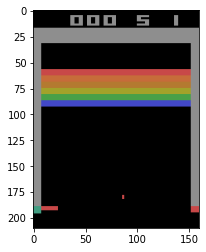

In [7]:
import matplotlib.pyplot as plt
import numpy as np

env.reset()
# run 20 steps so that the ball appears in the picture
for _ in range(20):
    action = np.random.choice([0,1,2,3])
    obs, reward, done, info = env.step(action)
plt.imshow(obs)
plt.show()

If you don't see a ball in the picture, rerun the above cell until you see a ball.

### 1.2. Process the Game Frames
The input size of the game frame is too large, we'll process the image to reduce the size while retaining vital information to train the model to win the game.

Specifically, we'll perform cropping, downsizing, and differencing before we feed the data into the model to train the agent. 

#### Cropping
We'll remove the top and the bottom of the game frame to reduce input size as follows.

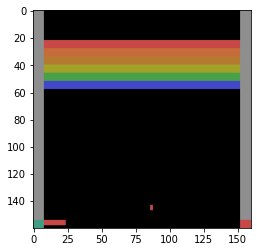

In [8]:
obs_cropped = obs[35:195]
plt.imshow(obs_cropped)
plt.show()

The size of the picture is now 160 by 160 by 3. We need to further reduce the size of the picture. 

#### Downsizing
We'll use every other row and every other column so that the input size is smaller. Further, we'll use just one of the three color channels to further reduce size, like so:

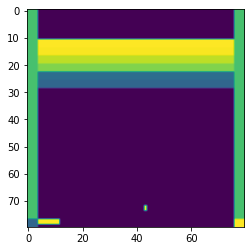

In [9]:
obs_downsized = obs_cropped[::2,::2,0]
plt.imshow(obs_downsized)
plt.show()

The size of the processed picture is now 80 by 80 by 1, a small fraction of the original size. However, the picture doesn't tell us the movement of the Breakout ball. We can potentially use two consecutive pictures, but that will double the input size to 80 by 80 by 2. With that, the number of parameters will be too large. The training will be too slow. Therefore, we'll use the difference between two consecutive frames. 

#### Differencing
We'll get the difference of the two consecutive frames after processing. The script below shows how. 

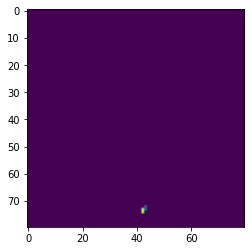

In [10]:
action = np.random.choice([2,3])
next_obs, reward, done, info = env.step(action)

next_obs_cropped = next_obs[35:195]
next_obs_downsized = next_obs_cropped[::2,::2,0]

dif = next_obs_downsized - obs_downsized
plt.imshow(dif)
plt.show()

Note the limitation in differencing the frames. The layers of the bricks disappear from the picture. This is not a problem in early stages of the game since as long as the ball is caught by the paddle, it will bounce up and hit a brick on the way up and you'll score no matter what. 

But in later stages of the game when many bricks are gone, you don't know where the remaining bricks are. It's impossible for the agent to aim at the bricks and score. 

We'll address this limitation in Chapter 18, by using the Baselines game wrapper. 

In [13]:
env.close()

Run the above line of code to close the game environment. 

## 2. Train the Agent Using Policy Gradients

We'll use policy gradients to train the agent. 

### 2.1. Changes we need to make when training the game

The first thing we need to change is how the actions are determined. In the Pong game, we used the following line of code: 

```python
action = 2 if np.random.uniform() < aprob else 3
```

We choose action 2 if the predicted probability is greater than a random number; otherwise we choose action 3. 

Now in the Breakout game, we have four actions to choose from. The model will make a prediction with four values, corresponding to the probabilities of the four actions. Therefore, we'll use this line of code: 

```python
action=np.random.choice([0,1,2,3], p=aprob)
```

We choose the four actions randomly, but the probability of each action is proportional to the predicted probability. For example, if the prediction probabilities are [0.2, 0.3, 0.1, 0.4], we'll pick action 0 with probability 20%, action 1 with probability 30%, action 2 with probability 10%, and action 3 with probability 40%. This is similar to exploration and exploitation in the training of the Q-tables. 


### 2.2. Counting the Number of Lives Remaining

In the Pong game, there are three possible rewards: -1, 0, and 1. Every time you fail to catch the ball, you get a reward of -1. 

However, in the Breakout game, there are only two possible rewards: 0 and 1. Every time you fail to catch the ball, the reward is still 0.  

Run the script below to show what I mean:

In [12]:
import gym
env = gym.make("Breakout-v0")
env.reset()
env.render()

while True:
    action = np.random.choice([0,1,2,3])
    obs, reward, done, info = env.step(action)
    print(reward, done, info)
    env.render()
    if info["ale.lives"]==4:
        break

0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0.0 False {'ale.lives': 5}
0

You should have seen that the paddle just missed the ball. However, the reward is still 0 in the last step. We therefore will hard code in a reward of -1 whenever the number of live remaining decreases by 1. 

### 2.3. The Script to Train the Model
The program below trains the model.

In [ ]:
import numpy as np
import pickle
import gym

# Hyperparameters
num_actions = 4
H = 200 
batch_size = 10 
learning_rate = 1e-4
gamma = 0.99 
decay_rate = 0.99 
D = 80 * 80 

# Create model
model = {}
model['W1'] = np.random.randn(H,D) / np.sqrt(D) 
model['W2'] = np.random.randn(num_actions,H) / np.sqrt(H)
  
grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } 
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } 

# Define the one-hot encoder and softmax functions
def onehot_encoder(action):
    onehot=np.zeros((1,num_actions))
    onehot[0,action]=1
    return onehot

def softmax(x):
    xi=np.exp(x)
    return xi/xi.sum() 

# Preprocss the pixels
def prepro(I):
  I = I[35:195] 
  I = I[::2,::2,0] 
  I[I == 144] = 0 
  I[I == 109] = 0 
  I[I != 0] = 1 
  return I.astype(np.float).ravel()

def discount_rewards(r):
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 
  logp = np.dot(model['W2'], h)
  p = softmax(logp)
  return p, h 

def policy_backward(eph, epdlogp):
  dW2 = np.dot(epdlogp.T, eph)
  dh = np.dot(epdlogp, model['W2'])
  dh[eph <= 0] = 0 
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Breakout-v0")
observation = env.reset()
prev_x = None 
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0

# Count the number of lives to determine when to give reward -1
lives=5

while episode_number<250000:
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, h = policy_forward(x)
  action=np.random.choice([0,1,2,3], p=aprob)
  # record various intermediates (needed later for backprop)
  xs.append(x) 
  hs.append(h) 
  y = onehot_encoder(action)
  # gradient for adjust weights, magic part
  dlogps.append(y - aprob) 

  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  # Not in Andrej's script, my addition to solve the reward structure problem
  if (lives-info["ale.lives"])==1:
    lives -= 1
    reward=-1
  reward_sum += reward

  drs.append(reward) 

  if done==True:
    episode_number += 1
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory
    
    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)
    # modulate the gradient with advantage (PG magic happens right here.)
    epdlogp *= discounted_epr 
    grad = policy_backward(eph, epdlogp)
    for k in model: grad_buffer[k] += grad[k] 

    # Reset lives to 5 after each episode
    lives=5
    fire=True
    reward_sum = 0    
    observation = env.reset() 
    prev_x = None        
    
    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] 
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) 
    
    # Show progress and save model
    if episode_number % 10 == 0: 
        print(f'this is episode {episode_number} with reward {reward_sum}')
    if episode_number % 100 == 0: 
        pickle.dump(model, open('v0breakpg.p', 'wb'))
    if episode_number % 10000 == 0: 
        pickle.dump(model, open(f'v0breakpg{episode_number}.p', 'wb'))


It takes several days to train the model. I trained the model half a million episodes. The trained model v0breakpg.p is paced in files/ch17/ in this GitHub repository. 

## 3. Test the Trained Model
We'll play the game using the trained model. We'll test it on 100 games and see what's the average score. 

### 3.1. Play One Game
You'll play one game using the trained model. You'll turn on the graphical rendering so you can see the game frames. The program below tests the game for one episode. Each time the ball hit a brick, there is a reward of 1. 

In [27]:
model = pickle.load(open('files/ch17/v0breakpg.p', 'rb'))
env = gym.make("Breakout-v0")
observation = env.reset()
prev_x = None 
reward_sum = 0

while True:

  env.render()
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  aprob, h = policy_forward(x)
  action=np.random.choice([0,1,2,3], p=aprob)

  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward  

  if done==True:
    print(f'reward total is {reward_sum}')
    break        

env.close()

reward total is 57.0


It's clear that the trained agent is able to catch the ball quite often. But it's far from perfect.

### 3.2. Play Multiple Games

We now play 5 games and turn off the graphical rendering. We'll see what the average score is.

In [29]:
model = pickle.load(open('files/ch17/v0breakpg.p', 'rb'))
env = gym.make("Breakout-v0")
observation = env.reset()
prev_x = None 
running_reward = []
reward_sum = 0
episode_number = 0

# See five episode in action
while episode_number<5:

  #env.render()
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  aprob, h = policy_forward(x)
  action=np.random.choice([0,1,2,3], p=aprob)

  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward  

  if done==True:
    episode_number += 1
    print(f'episode {episode_number} reward total was {reward_sum}')
    running_reward.append(reward_sum)
    reward_sum = 0    
    observation = env.reset() # reset env
    prev_x = None        
    
print(f'running mean: {np.mean(running_reward)}')

episode 1 reward total was 36.0
episode 2 reward total was 33.0
episode 3 reward total was 25.0
episode 4 reward total was 69.0
episode 5 reward total was 25.0
running mean: 37.6


The average score is 37.6 per episode.

Next, we'll search for episodes that the agent successfully sends the ball to the back of the wall to score more efficiently. 

## 4. Search for Successful Episodes
If the agent sends the ball to the back of the wall, the ball can hit multiple bricks and have a high score in the episode. We therefore look for an episode with total rewards above, say, 100. 

### 4.1. Collect Successful Episodes
We'll first record a full game using the trained model.

The script below accomplishes that.

In [ ]:
import numpy as np
import pickle
import gym
import imageio

# Hyperparameters
num_actions = 4
D = 80 * 80 
model = pickle.load(open('files/ch17/v0breakpg.p', 'rb'))

def onehot_encoder(action):
    onehot=np.zeros((1,num_actions))
    onehot[0,action]=1
    return onehot

def softmax(x):
    xi=np.exp(x)
    return xi/xi.sum() 

# Preprocss the pixels
def prepro(I):
  I = I[35:195] 
  I = I[::2,::2,0] 
  I[I == 144] = 0 
  I[I == 109] = 0 
  I[I != 0] = 1 
  return I.astype(np.float).ravel()

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 
  logp = np.dot(model['W2'], h)
  p = softmax(logp)
  return p, h 

env = gym.make("Breakout-v0")
observation = env.reset()
prev_x = None 
running_reward = []
reward_sum = 0
episode_number = 0


frames=[]
while True:
  frames.append(env.render(mode='rgb_array'))
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  aprob, h = policy_forward(x)
  action=np.random.choice([0,1,2,3], p=aprob)

  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward  

  if done==True:
    episode_number += 1
    print(f'episode {episode_number} reward total was {reward_sum}')
    # usually, if episode reward is above 60, you have a tunnel
    if reward_sum>100:
        pickle.dump(frames, open(f'files/ch17/frames{episode_number}.p', 'wb'))
        imageio.mimsave(f"files/ch17/frames{episode_number}.gif", frames, fps=60)
        break
    running_reward.append(reward_sum)
    reward_sum = 0    
    observation = env.reset() 
    prev_x = None 
    frame = []
    
print(f'running mean: {np.mean(running_reward)}')

It usually takes 5 to 10 minutes for you to have an episode with rewards above 100. Once done, you'll have an animation in your local folder. 

The animation is usually fairly long. We need to zoom in on the part of the animation that the agent sends the ball to the back of the wall. 

### 4.2. Zoom in on Certain Steps
Next, we'll zoom in on the steps of the game when the agent sends the ball to the back of the wall. 
For example, I have recorded an episode named frames84.p. So I extract the interesting parts of the video as follows.

In [2]:
import numpy as np
import pickle
import imageio

frames = pickle.load(open('files/ch17/frames84.p', 'rb'))
imageio.mimsave("files/ch17/episode84.gif", frames[800:-10], fps=240)


The resulting animation episode84.gif looks as follows:

In [3]:
%%HTML 
<img src="https://gattonweb.uky.edu/faculty/lium/ml/episode84.gif" />

I have recorded another episode named frames606.p. So I extract the interesting parts of the video as follows.

In [4]:
frames = pickle.load(open('files/ch17/frames606.p', 'rb'))
imageio.mimsave("files/ch17/episode606.gif", frames[600:], fps=240)

The resulting animation episode606.gif looks as follows:

In [5]:
%%HTML 
<img src="https://gattonweb.uky.edu/faculty/lium/ml/episode606.gif" />

### 4.3. Combine the Animations
We'll combine the two animations into one.

In [8]:
frames1 = pickle.load(open('files/ch17/frames84.p', 'rb'))
frames1=frames1[800:-10]
frames1=frames1+frames1
print(len(frames1))


frames2 = pickle.load(open('files/ch17/frames606.p', 'rb'))
frames2=frames2[600:]
print(len(frames2))

fs = []
for i in range(len(frames2)):
    f = frames2[i]
    rf = frames1[i]
    middle = np.full(f.shape, 255).astype("uint8")
    frf = np.concatenate([f, middle, rf], axis=1)
    fs.append(frf)
imageio.mimsave('files/ch17/breakout_tunnel.gif', fs, fps=240) 

484
378


The animation looks as follows:

In [9]:
%%HTML
<img src="https://gattonweb.uky.edu/faculty/lium/ml/breakout_tunnel.gif" />

It's clear that the agent has learned to send the ball to the back of the wall to score more efficiently. This is because doing so earns higher rewards. The training has adjusted the parameters based on the rewards, and that is the essence of policy gradients. 